## Libraries and settings

In [1]:

# Libraries
import os
# os.system('pip install yfinance') to install the yfinance in the current environment
import json
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import sqlite3
from scipy import stats 


# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(f'Current working directory: {os.getcwd()}')

Current working directory: /workspaces/Scientific-Programming_GroupProject


## Download qoutes (stock information) into one file

In [2]:
# List of stocks
stocks = ['AAPL', 'GME', 'GOOGL', 'META', 'NFLX']

# Empty list for all stock data
all_data = []

for symbol in stocks:
    print(f"Downloading data for {symbol}...")

    data = yf.download(symbol, start='2024-11-01', end='2025-04-25', auto_adjust=False)
    
    if data.empty:
        print(f"No data for {symbol} in this range.")
    else:
        print(f"Data found for {symbol}: {len(data)} rows, from {data.index.min().date()} to {data.index.max().date()}.")

#    data['Symbol'] = symbol  # Add the stock symbol
#    data.reset_index(inplace=True)  # Make 'Date' a column
#        all_data.append(data)
# Reset index to make 'Date' a column
    # Flatten multi-index if it sneaks in
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data = data.reset_index()

    
    # Select only the relevant columns (avoid multi-index issues)
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    # Add the stock symbol
    data['Symbol'] = symbol
    # Append tidy data
    all_data.append(data)





# Combine into tidy format (stacked rows)
final_df = pd.concat(all_data, ignore_index=True)

# Check for NaNs 

print("\n--- NaN counts per stock ---")
nan_summary = final_df.groupby('Symbol').apply(lambda x: x.isna().sum())
print(nan_summary)





[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data found for AAPL: 118 rows, from 2024-11-01 to 2025-04-24.
Data found for GME: 118 rows, from 2024-11-01 to 2025-04-24.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data found for GOOGL: 118 rows, from 2024-11-01 to 2025-04-24.
Data found for META: 118 rows, from 2024-11-01 to 2025-04-24.


[*********************100%***********************]  1 of 1 completed

Data found for NFLX: 118 rows, from 2024-11-01 to 2025-04-24.

--- NaN counts per stock ---
Price   Date  Open  High  Low  Close  Adj Close  Volume  Symbol
Symbol                                                         
AAPL       0     0     0    0      0          0       0       0
GME        0     0     0    0      0          0       0       0
GOOGL      0     0     0    0      0          0       0       0
META       0     0     0    0      0          0       0       0
NFLX       0     0     0    0      0          0       0       0


In [3]:
# Preview all data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 

# Check unique symbols and row counts
print("\n--- Stock counts ---")
print(final_df['Symbol'].value_counts())

pd.set_option('display.max_rows', 600)  # Adjust to fit all rows
print(final_df.sort_values(by=['Symbol', 'Date']))

#Save to CSV
csv_file = 'stocks_data.csv'

# Delete existing CSV if it exists
if os.path.exists(csv_file):
    os.remove(csv_file)
    print("Existing CSV '{csv_file}' deleted.")

# Save the final DataFrame to CSV
final_df.to_csv(csv_file, index=False)
print("Data saved to '{csv_file}'.")



--- Stock counts ---
Symbol
AAPL     118
GME      118
GOOGL    118
META     118
NFLX     118
Name: count, dtype: int64
Price       Date         Open         High          Low        Close  \
0     2024-11-01   220.970001   225.350006   220.270004   222.910004   
1     2024-11-04   220.990005   222.789993   219.710007   222.009995   
2     2024-11-05   221.800003   223.949997   221.139999   223.449997   
3     2024-11-06   222.610001   226.070007   221.190002   222.720001   
4     2024-11-07   224.630005   227.880005   224.570007   227.479996   
5     2024-11-08   227.169998   228.660004   226.410004   226.960007   
6     2024-11-11   225.000000   225.699997   221.500000   224.229996   
7     2024-11-12   224.550003   225.589996   223.360001   224.229996   
8     2024-11-13   224.009995   226.649994   222.759995   225.119995   
9     2024-11-14   225.020004   228.869995   225.000000   228.220001   
10    2024-11-15   226.399994   226.919998   224.270004   225.000000   
11    2024-11-18

In [4]:
# Save to SQLite
db_file = 'stocks.db'

# Connect to SQLite (creates the DB if it doesn't exist)
conn = sqlite3.connect(db_file)

# Drop the existing table (if any)
conn.execute("DROP TABLE IF EXISTS stocks;")
print("Existing table 'stocks' dropped.")

# Save DataFrame to SQLite
final_df.to_sql('stock_prices', conn, if_exists='replace', index=False)
print("Data saved to SQLite database '{db_file}'.")

# Close the connection
conn.close()

Existing table 'stocks' dropped.
Data saved to SQLite database '{db_file}'.


TO CHECK ??? Strategy A and Strategy B - Comparison ---- changed by Ana

In [5]:
# Read the data from the CSV file
df = pd.read_csv('stocks_data.csv')

def calculate_strategies(df):
    df = df.sort_values(by=['Symbol', 'Date'])  # Ensure chronological order

    # Daily profit: Buy at Open, Sell at Close (same day)
    df['Strategy_A'] = df['Close'] - df['Open']
    
    # Daily profit: Buy at Close, Sell next day's Open
    df['Strategy_B'] = df.groupby('Symbol')['Open'].shift(-1) - df['Close']

    # Cumulative profit over time (assuming 1 share per day)
    df['Cumulative_A'] = df.groupby('Symbol')['Strategy_A'].cumsum()
    df['Cumulative_B'] = df.groupby('Symbol')['Strategy_B'].cumsum()

    return df


cols_to_convert = ['Open', 'Close']
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Apply the strategy calculation
processed_df = calculate_strategies(df)

# Preview new columns
# Steivan print(processed_df[['Date', 'Symbol', 'Open', 'Close', 'Strategy_A', 'Strategy_B', 'Cumulative_A', 'Cumulative_B']].head(20))

# Set pandas to display ALL rows (no truncation)
pd.set_option('display.max_rows', None)

# Print all rows for the selected columns
print(processed_df[['Date', 'Symbol', 'Open', 'Close', 'Strategy_A', 'Strategy_B', 'Cumulative_A', 'Cumulative_B']])



           Date Symbol         Open        Close  Strategy_A  Strategy_B  \
0    2024-11-01   AAPL   220.970001   222.910004    1.940002   -1.919998   
1    2024-11-04   AAPL   220.990005   222.009995    1.019989   -0.209991   
2    2024-11-05   AAPL   221.800003   223.449997    1.649994   -0.839996   
3    2024-11-06   AAPL   222.610001   222.720001    0.110001    1.910004   
4    2024-11-07   AAPL   224.630005   227.479996    2.849991   -0.309998   
5    2024-11-08   AAPL   227.169998   226.960007   -0.209991   -1.960007   
6    2024-11-11   AAPL   225.000000   224.229996   -0.770004    0.320007   
7    2024-11-12   AAPL   224.550003   224.229996   -0.320007   -0.220001   
8    2024-11-13   AAPL   224.009995   225.119995    1.110001   -0.099991   
9    2024-11-14   AAPL   225.020004   228.220001    3.199997   -1.820007   
10   2024-11-15   AAPL   226.399994   225.000000   -1.399994    0.250000   
11   2024-11-18   AAPL   225.250000   228.020004    2.770004   -1.040009   
12   2024-11

Steivan: AAPL only 

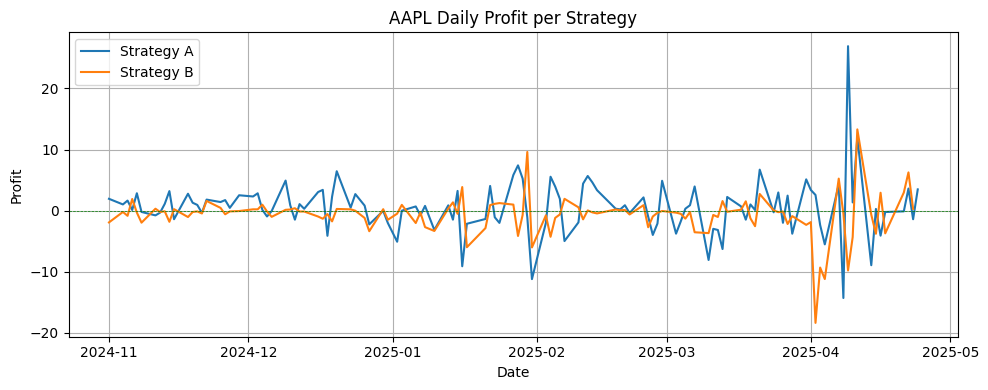

1


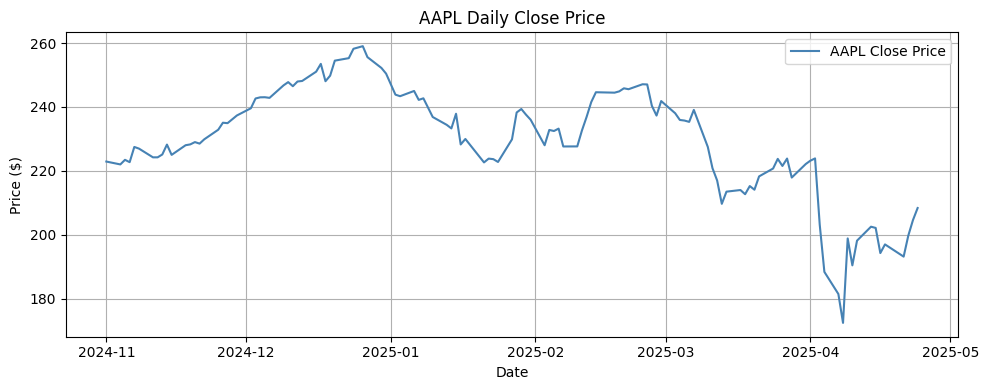

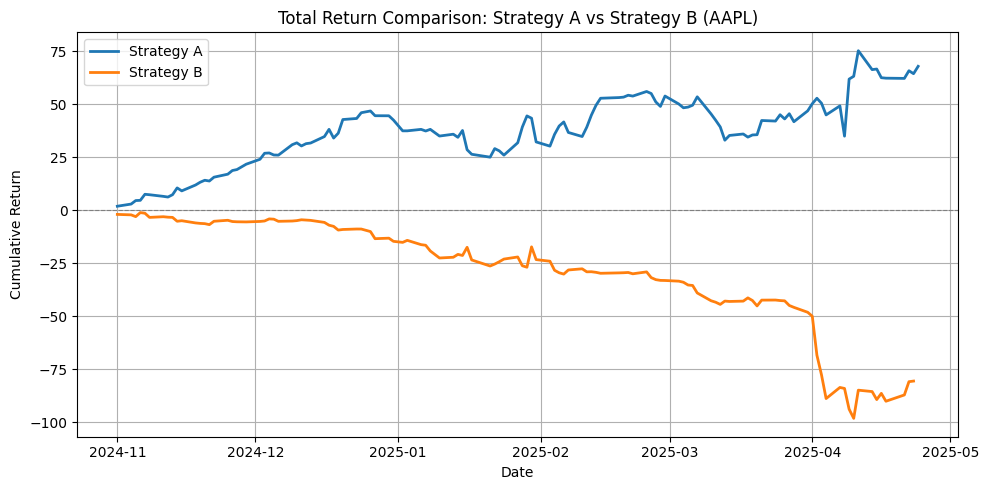

In [6]:
# Filter for AAPL only
stock_data = processed_df[processed_df['Symbol'] == 'AAPL'].copy()

# Make sure 'Date' is in datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(stock_data['Date'], stock_data['Strategy_A'], label='Strategy A')
plt.plot(stock_data['Date'], stock_data['Strategy_B'], label='Strategy B')
plt.title('AAPL Daily Profit per Strategy')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.axhline(0, color='green', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Get axis before showing the plot
ax = plt.gca()
plt.show()


print(stock_data['Strategy_B'].isna().sum())  # count of missing values



# Filter for AAPL
stock_data = processed_df[processed_df['Symbol'] == 'AAPL'].copy()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Plot daily closing price
plt.figure(figsize=(10, 4))
plt.plot(stock_data['Date'], stock_data['Close'], label='AAPL Close Price', color='steelblue')
plt.title('AAPL Daily Close Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Ensure 'Date' is datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Calculate cumulative returns
cumulative_a = stock_data['Strategy_A'].cumsum()
cumulative_b = stock_data['Strategy_B'].cumsum()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(stock_data['Date'], cumulative_a, label='Strategy A', linewidth=2)
plt.plot(stock_data['Date'], cumulative_b, label='Strategy B', linewidth=2)
plt.title('Total Return Comparison: Strategy A vs Strategy B (AAPL)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


all the stocks

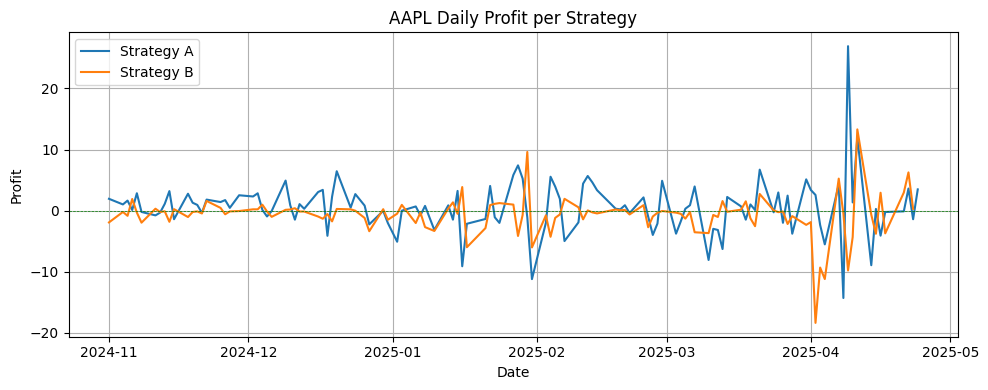

AAPL - Missing values in Strategy B: 1


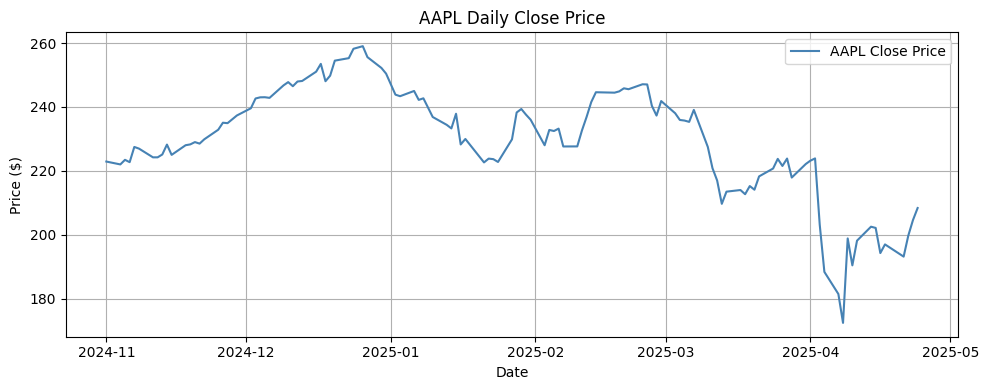

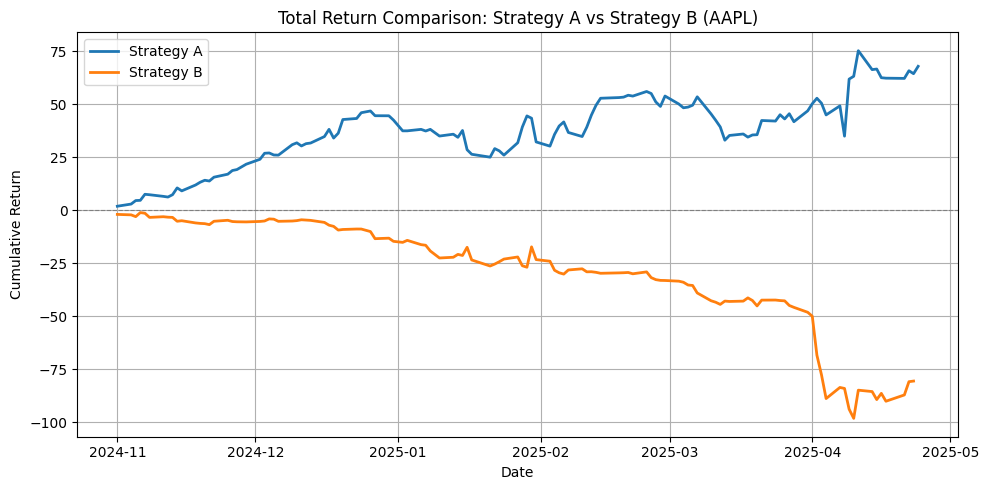

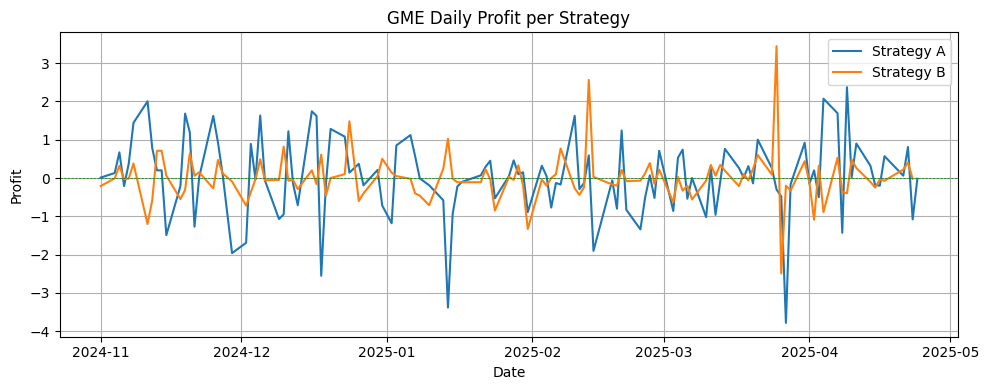

GME - Missing values in Strategy B: 1


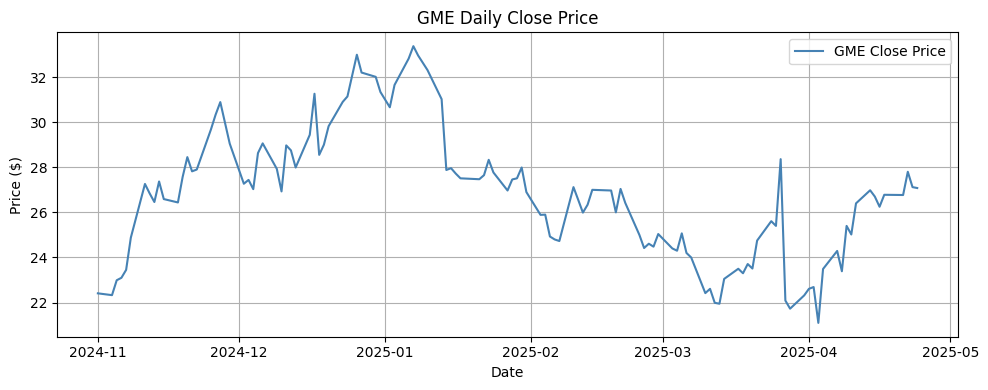

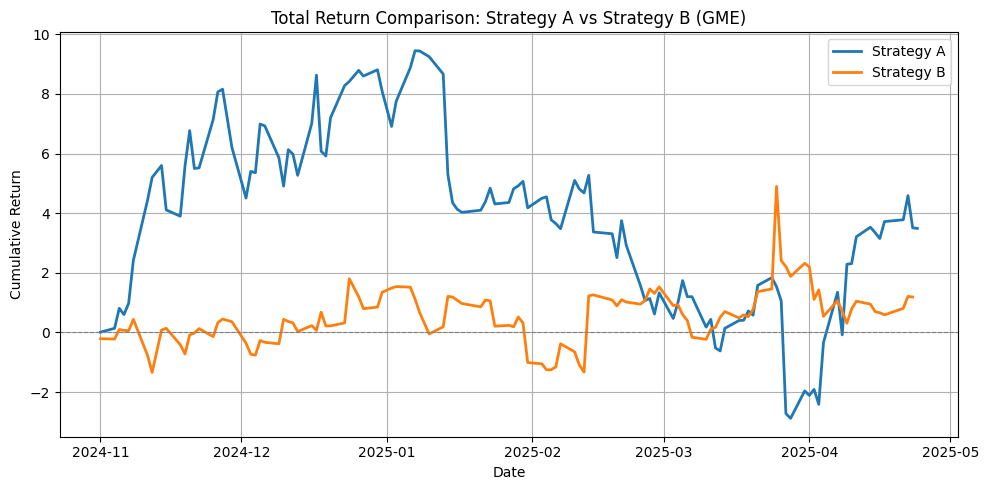

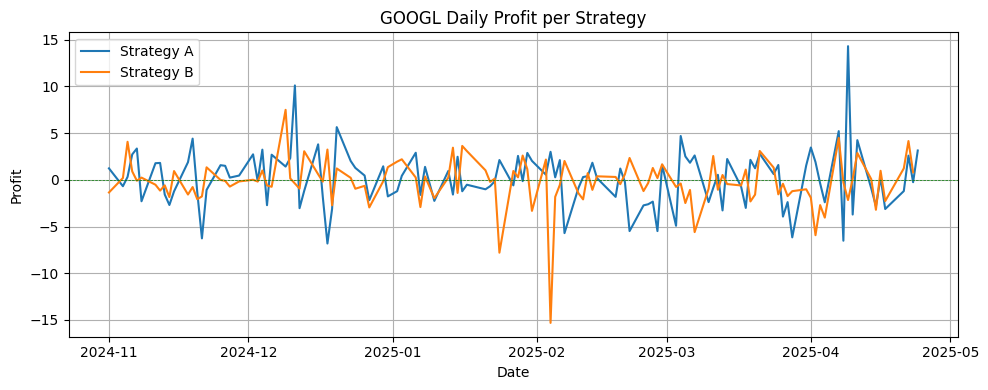

GOOGL - Missing values in Strategy B: 1


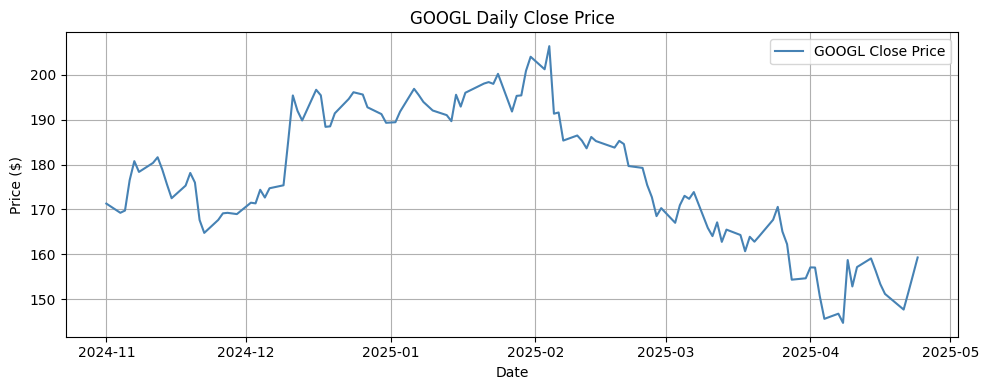

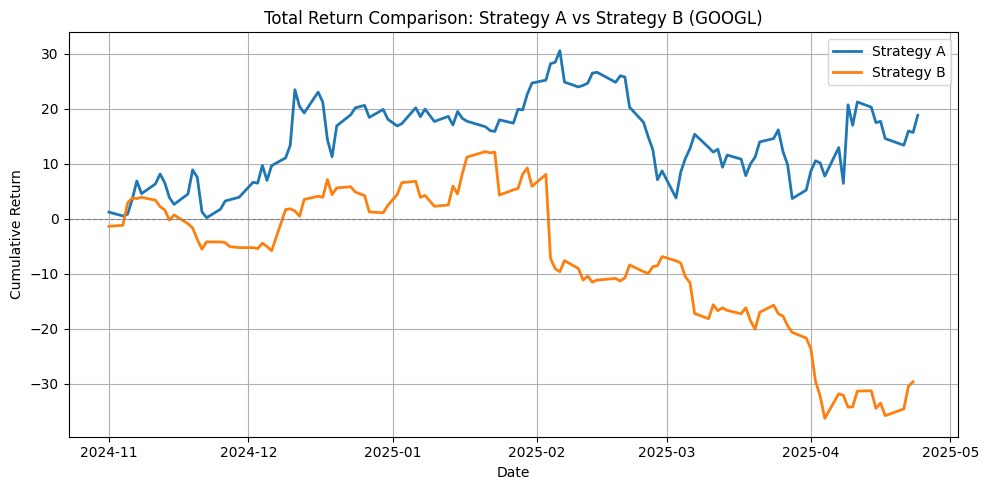

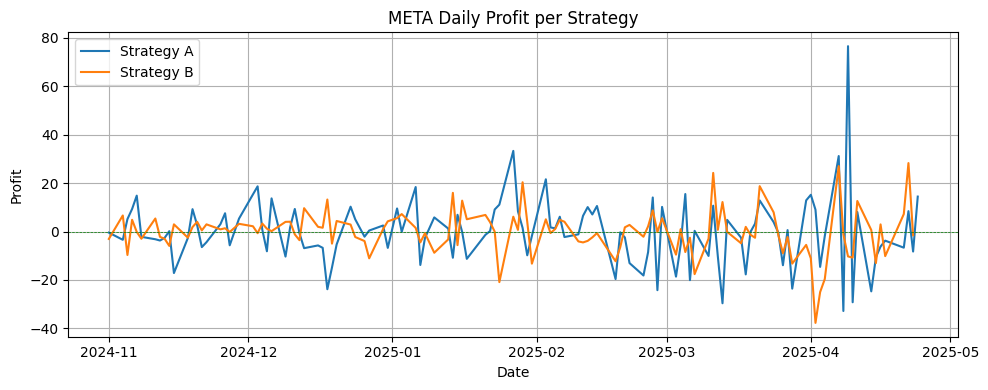

META - Missing values in Strategy B: 1


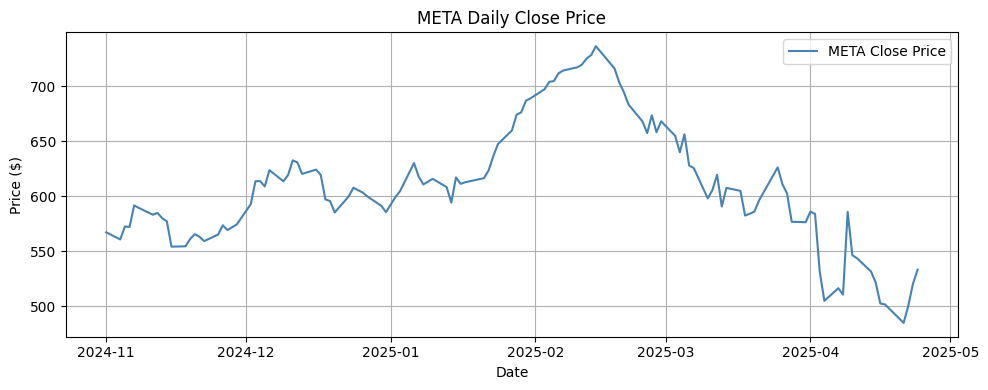

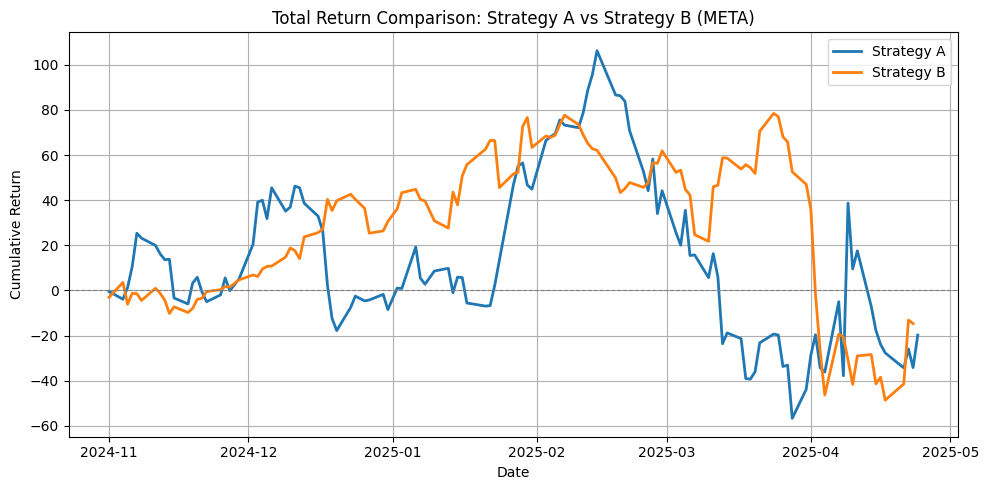

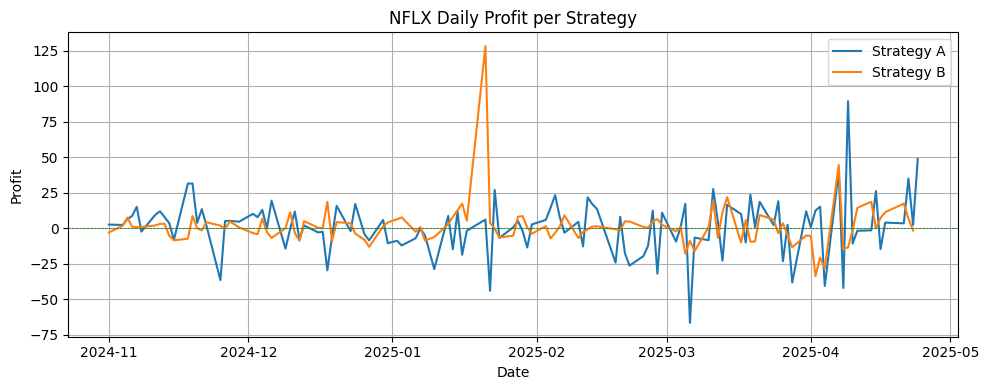

NFLX - Missing values in Strategy B: 1


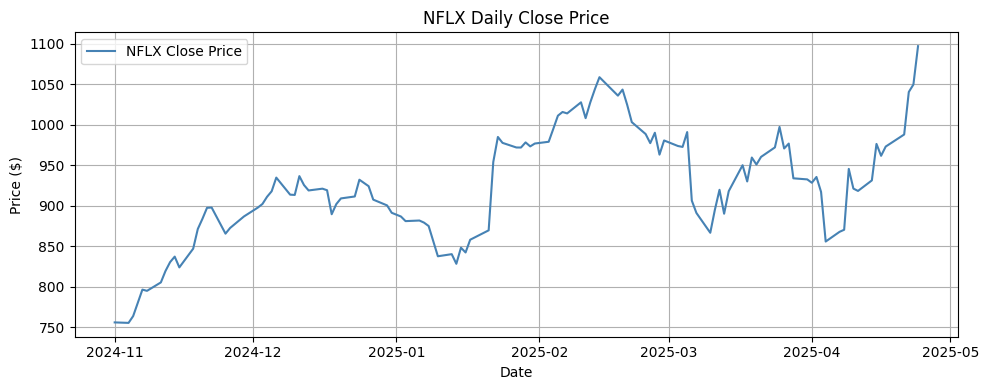

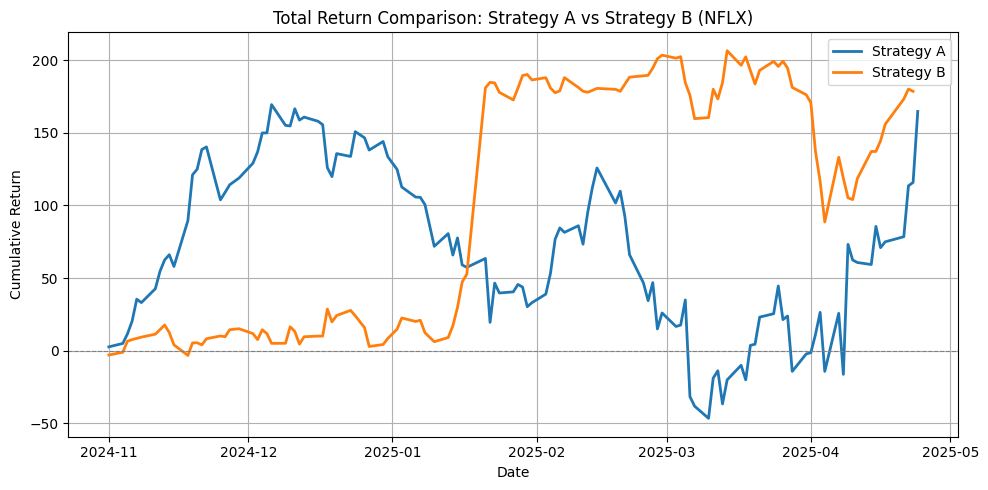

In [7]:
# Loop through each stock symbol
for stock in processed_df['Symbol'].unique():
    stock_data = processed_df[processed_df['Symbol'] == stock].copy()
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    
    # Plot daily profits (Strategy A & B)
    plt.figure(figsize=(10, 4))
    plt.plot(stock_data['Date'], stock_data['Strategy_A'], label='Strategy A')
    plt.plot(stock_data['Date'], stock_data['Strategy_B'], label='Strategy B')
    plt.title(f'{stock} Daily Profit per Strategy')
    plt.xlabel('Date')
    plt.ylabel('Profit')
    plt.axhline(0, color='green', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Count and print missing values in Strategy B
    missing_b = stock_data['Strategy_B'].isna().sum()
    print(f"{stock} - Missing values in Strategy B: {missing_b}")
    
    # Plot daily closing price
    plt.figure(figsize=(10, 4))
    plt.plot(stock_data['Date'], stock_data['Close'], label=f'{stock} Close Price', color='steelblue')
    plt.title(f'{stock} Daily Close Price')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Calculate cumulative returns
    cumulative_a = stock_data['Strategy_A'].cumsum()
    cumulative_b = stock_data['Strategy_B'].cumsum()
    
    # Plot cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(stock_data['Date'], cumulative_a, label='Strategy A', linewidth=2)
    plt.plot(stock_data['Date'], cumulative_b, label='Strategy B', linewidth=2)
    plt.title(f'Total Return Comparison: Strategy A vs Strategy B ({stock})')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Statistical Analysis

In [8]:
for stock in stocks:
    stock_data = processed_df[processed_df['Symbol'] == stock]
    print(f"{stock} - Total rows: {len(stock_data)}")
    print(f"{stock} - NaNs in Strategy_A: {stock_data['Strategy_A'].isna().sum()}, Strategy_B: {stock_data['Strategy_B'].isna().sum()}\n")


AAPL - Total rows: 118
AAPL - NaNs in Strategy_A: 0, Strategy_B: 1

GME - Total rows: 118
GME - NaNs in Strategy_A: 0, Strategy_B: 1

GOOGL - Total rows: 118
GOOGL - NaNs in Strategy_A: 0, Strategy_B: 1

META - Total rows: 118
META - NaNs in Strategy_A: 0, Strategy_B: 1

NFLX - Total rows: 118
NFLX - NaNs in Strategy_A: 0, Strategy_B: 1



In [9]:


# Loop through each stock for analysis
for stock in stocks:
    print(f"\n--- Statistical Analysis for {stock} ---")

    # Filter data for the current stock
    stock_data = processed_df[processed_df['Symbol'] == stock].copy()

    # Drop rows with NaNs in strategies
    stock_data = stock_data.dropna(subset=['Strategy_A', 'Strategy_B'])

     # Check if enough data exists
    if len(stock_data) < 2:
        print(f"Not enough data for {stock} to perform statistical analysis.\n")
        continue

    # Extract the profits
    profits_a = stock_data['Strategy_A']
    profits_b = stock_data['Strategy_B']

    # Calculate means
    mean_a = profits_a.mean()
    mean_b = profits_b.mean()

    # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(profits_a, profits_b)

    # Output results
    print(f"Mean profit (Strategy A - Open→Close): {mean_a:.4f}")
    print(f"Mean profit (Strategy B - Close→Next Open): {mean_b:.4f}")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Interprete the p-value & define the better strategy

    if p_value < 0.05:
        better = "A" if mean_a > mean_b else "B"
        print("Result: Statistically significant difference between the two strategies!")
        print(f"Strategy {better} is statistically better.")
    else:
        print("Result: No significant difference between the two strategies.")



--- Statistical Analysis for AAPL ---
Mean profit (Strategy A - Open→Close): 0.5509
Mean profit (Strategy B - Close→Next Open): -0.6883
T-statistic: 2.4036
P-value: 0.0178
Result: Statistically significant difference between the two strategies!
Strategy A is statistically better.

--- Statistical Analysis for GME ---
Mean profit (Strategy A - Open→Close): 0.0300
Mean profit (Strategy B - Close→Next Open): 0.0102
T-statistic: 0.1789
P-value: 0.8583
Result: No significant difference between the two strategies.

--- Statistical Analysis for GOOGL ---
Mean profit (Strategy A - Open→Close): 0.1344
Mean profit (Strategy B - Close→Next Open): -0.2533
T-statistic: 1.0132
P-value: 0.3131
Result: No significant difference between the two strategies.

--- Statistical Analysis for META ---
Mean profit (Strategy A - Open→Close): -0.2922
Mean profit (Strategy B - Close→Next Open): -0.1256
T-statistic: -0.1127
P-value: 0.9104
Result: No significant difference between the two strategies.

--- Statist

## LLM Integration

In [10]:
%pip install openai
import os
import openai

# Initialize the OpenAI client with your API key
openai.api_key = "your_API_key_here"


# Financial news headlines
headlines = [
    "Apple reports record quarterly revenue beating analyst expectations",
    "GameStop shares surge after meme stock rally reignites",
    "Google faces antitrust lawsuit from European regulators",
    "Meta introduces AI-powered features to boost ad revenue",
    "Netflix subscriber growth slows amid increased competition"
]

news_input = "\n".join(headlines)

# Create the chat completion
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user", "content": "Summarize Apple's latest earnings report."}
    ],
    max_tokens=50,
    temperature=0.3
)
print(response.choices[0].message.content.strip())





[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


APIRemovedInV1: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


## WEB-Scrapping

In [ ]:
# Phase 7
# Build a Streamlit dashboard: Input: stock ticker, date range Output: charts, metrics, LLM insight

with open("streamlit.py", "r") as file:
    content = file.read()
print(content)

# Phase 7
# Build a Streamlit dashboard: Input: stock ticker, date range Output: charts, metrics, LLM insight

import streamlit as st
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image

image = Image.open("return_comparison.png")



# Set the title of the app
st.title("Stock Price Analysis Dashboard")
st.write("This dashboard allows you to analyze stock prices and strategies.")
# Sidebar for user input
st.sidebar.header("User Input")
# Stock ticker input
stock_ticker = st.sidebar.text_input("Enter Stock Ticker (e.g., AAPL):", "AAPL")
# Date range input
start_date = st.sidebar.date_input("Start Date", datetime(2024, 11, 1))
end_date = st.sidebar.date_input("End Date", datetime(2025, 4, 1))
# Convert date inputs to string
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')
# Start application
st.write(f"Analyzing data for {stock_ticker} from {start_date_str} to {end_date_str}")
# Filter data based on user input


